# Elevator traveling distance using the Kalman filter

## Introduction

Problem: Measure traveling distance of the elevator using the adxl345 accelerometer. The problem occurs because accelerometer has a big error. On the ploted graph it is shown how does the Z axis taken from the accelerometer looks like when the adxl345 is still and the elevator is not moving.

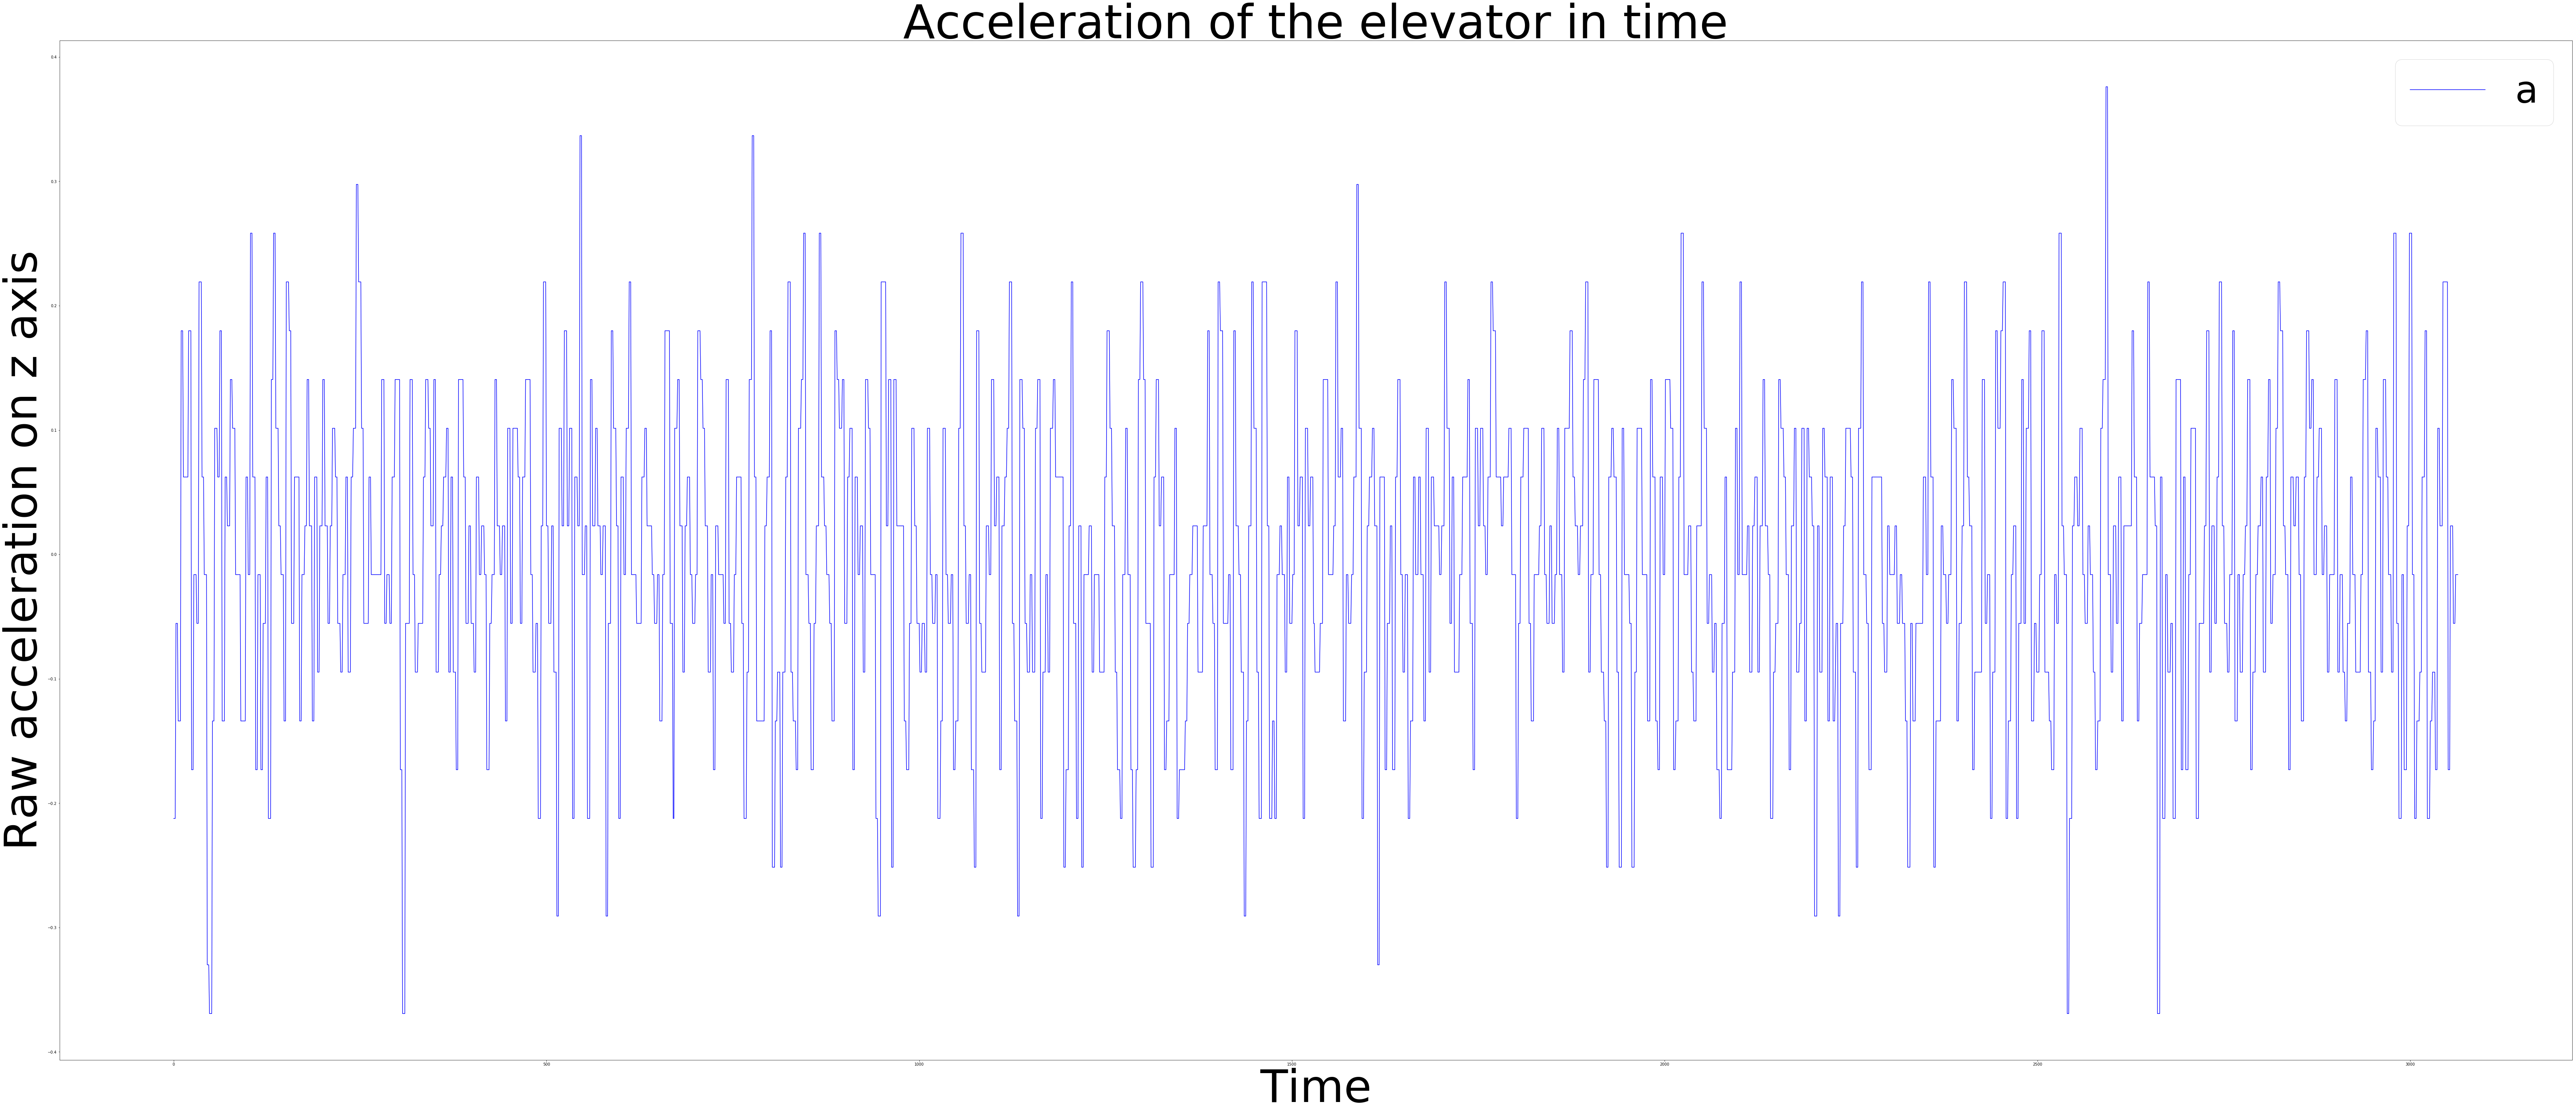

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pylab
import matplotlib.mlab as mlab
import math

log = open('log_not_moving.dat', 'r')
temp = log.read()
log.close()

az_raw = temp.split('\n')

pylab.figure(figsize=(120,50))
pylab.plot(range(len(az_raw)),az_raw,'b')
pylab.xlabel('Time', fontsize=120)
pylab.ylabel('Raw acceleration on z axis', fontsize=120)
pylab.title('Acceleration of the elevator in time', fontsize=124)
pylab.legend('az', fontsize=100)
pylab.show()

## Importing raw data

On the next graph, raw data from the accelerometer was taken while the elevator was moving.

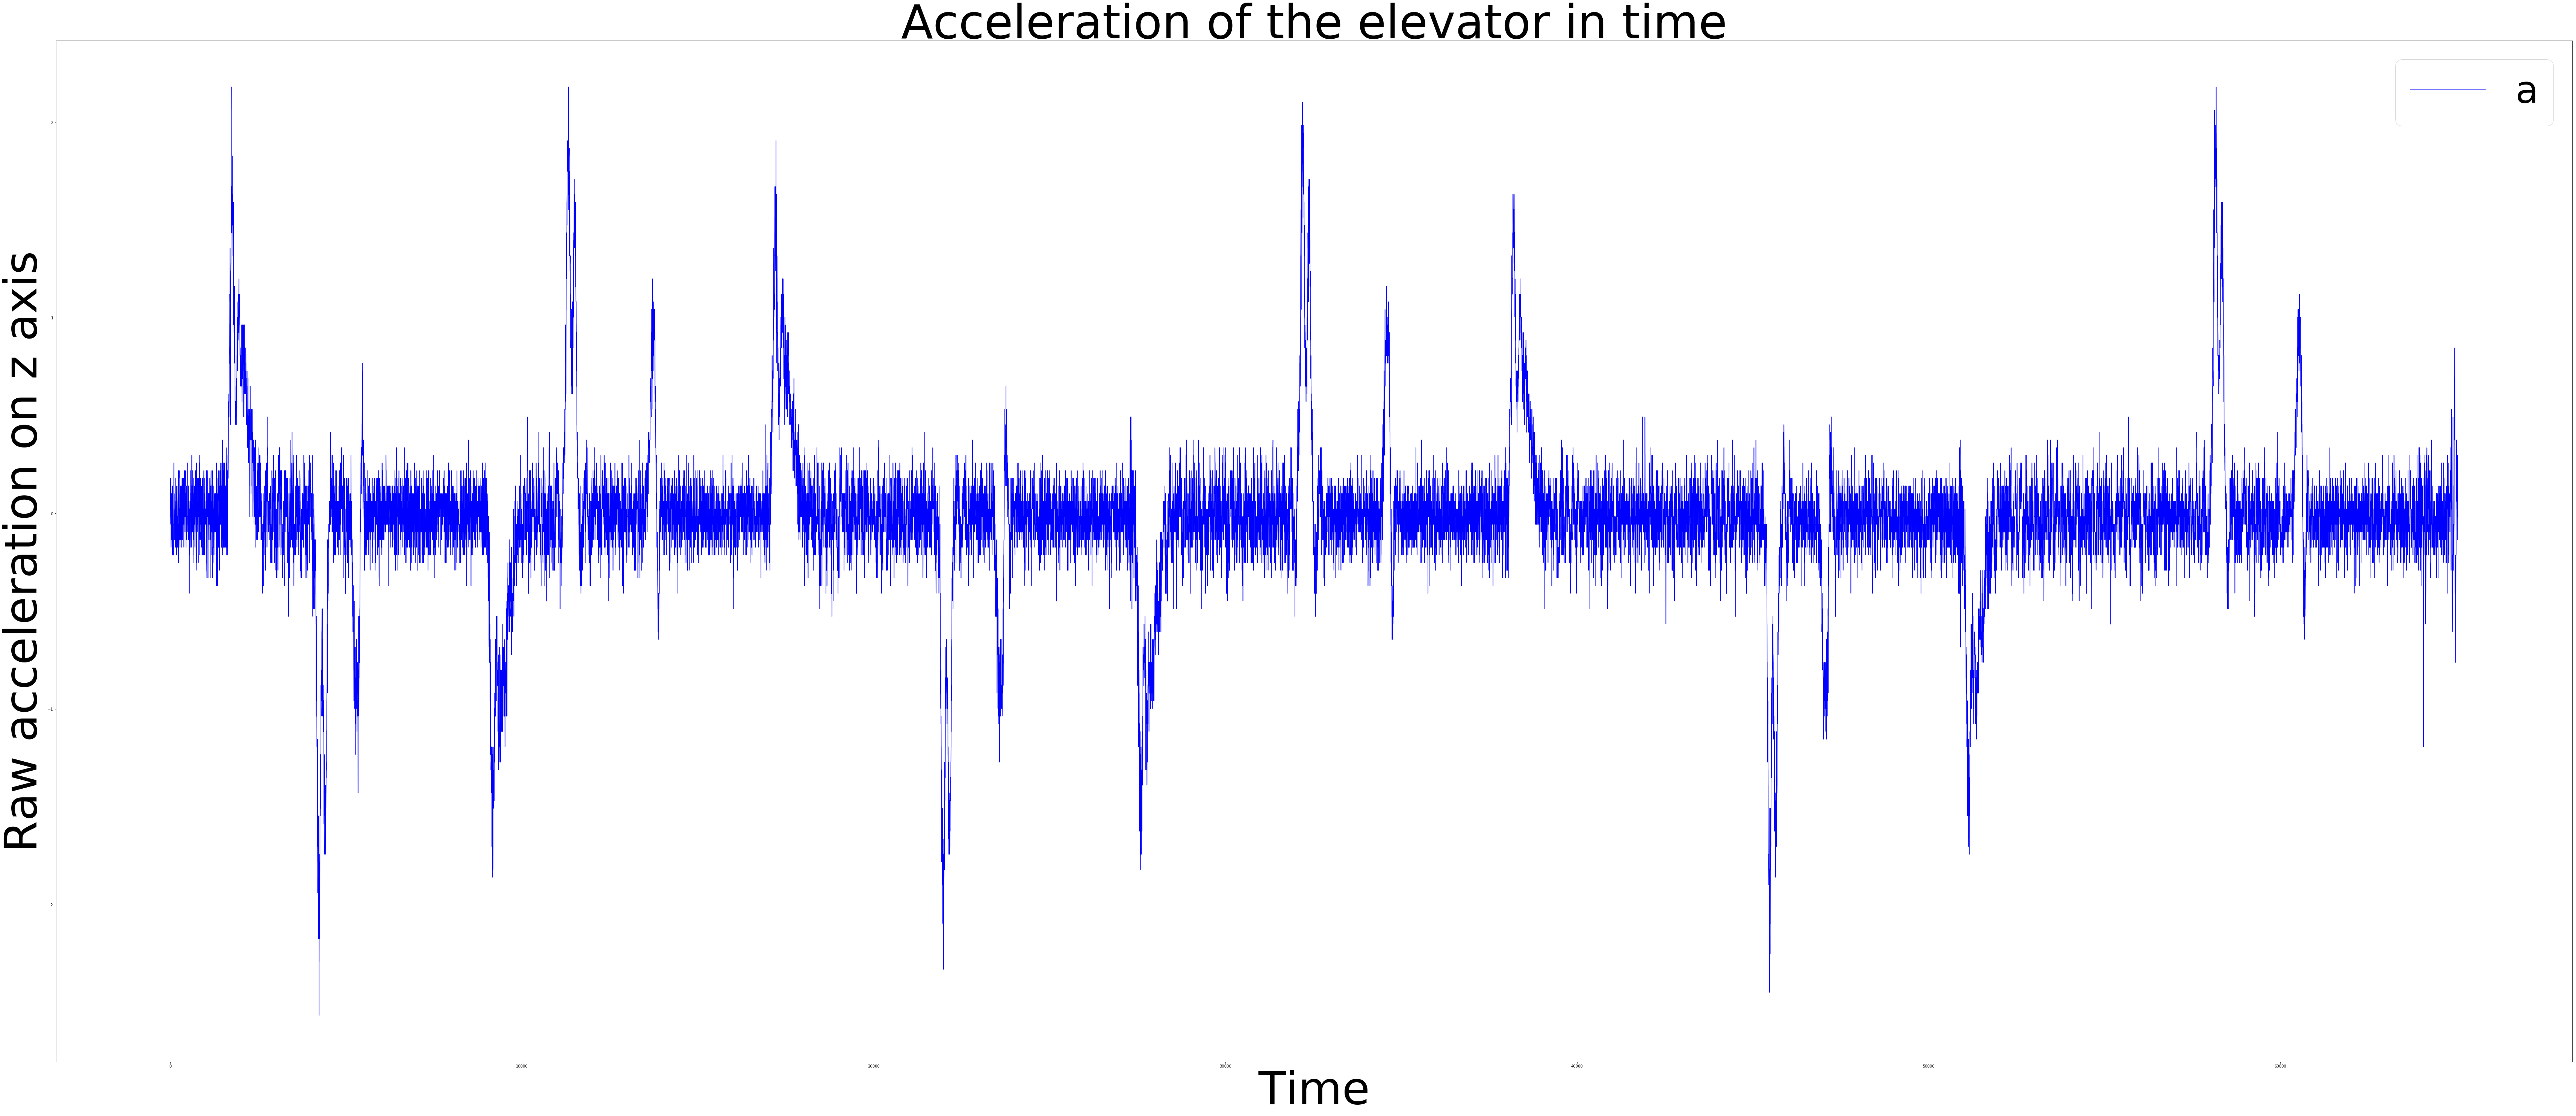

In [90]:
log = open('log.dat', 'r')
temp = log.read()
log.close()

az_raw = temp.split('\n')

pylab.figure(figsize=(120,50))
pylab.plot(range(len(az_raw)),az_raw,'b')
pylab.xlabel('Time', fontsize=120)
pylab.ylabel('Raw acceleration on z axis', fontsize=120)
pylab.title('Acceleration of the elevator in time', fontsize=124)
pylab.legend('az', fontsize=100)
pylab.show()

We could see that there is a pattern in the readings. 

# Data preparation

Before any further calculations we need to lower the error of the data comming from the sensor. We could do a simple average of last 40 measurements in order to lower the error and also use Kalman filter for that purpose. It will be shown that Kalman filter does a better job.

## Averaging the data

Like shown in the "Design And Implementation Of Algorithm For Estimation Of Elevator Travel Distance Using Smartphone Accelerometer" paper we could average the raw data and get the better results.

On the next graph comparation of the raw data and filtered data is shown.

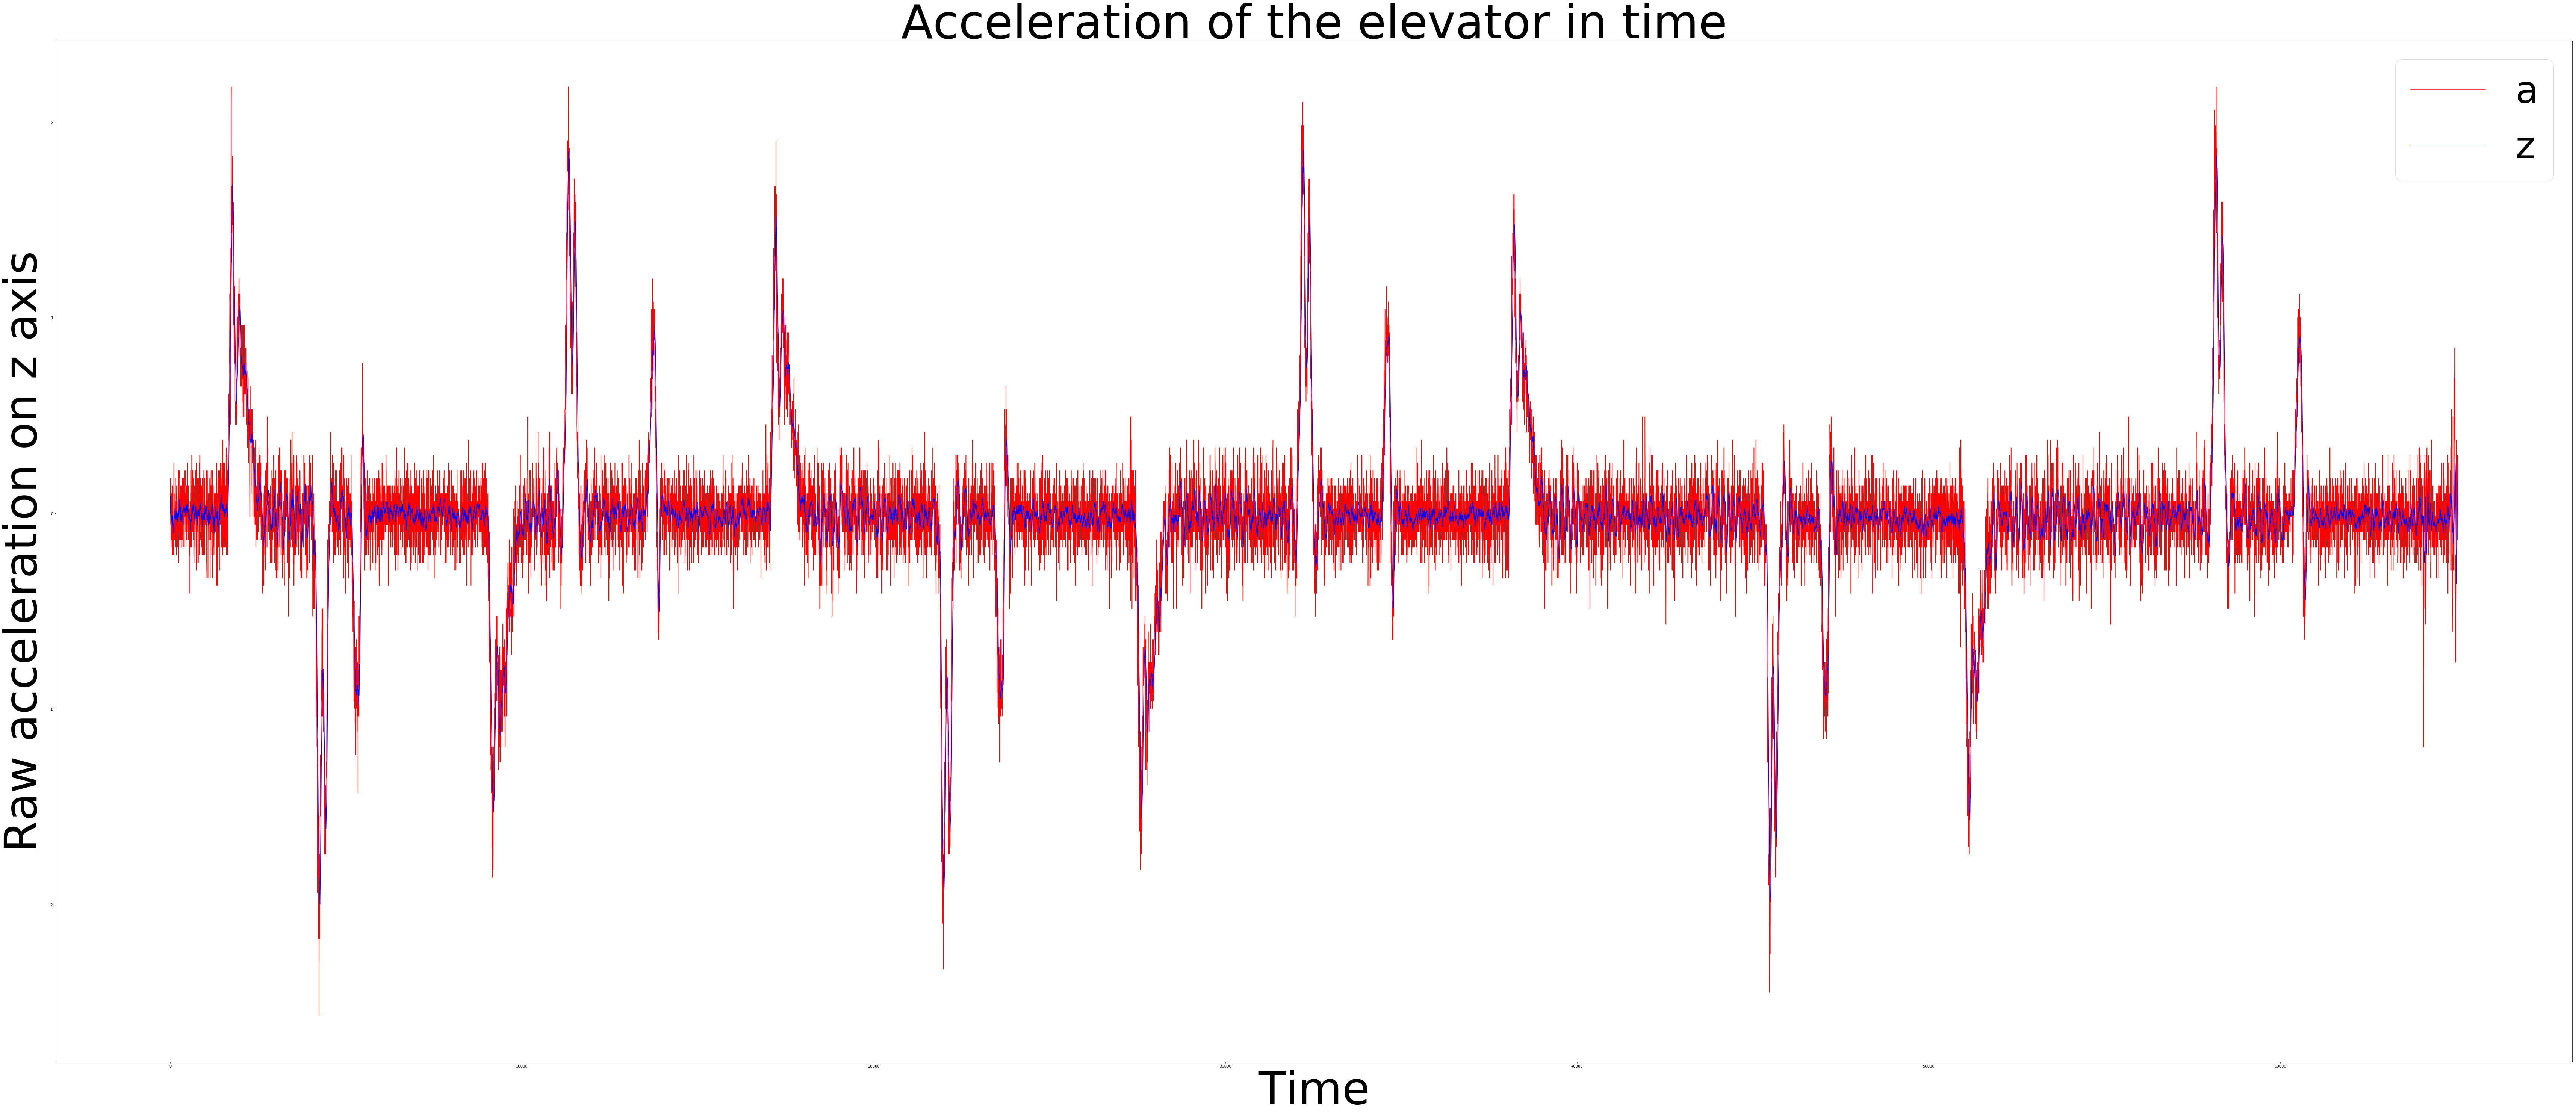

In [91]:
az_average = []
vz_average = []
i = 0

for z in range (0, len(az_raw)):

    mean40 = 0.0
    sum = 0.0
    n = 0
    br = 0
    if z > 40:
        n = z - 40
    for i in range(n, z):
        #if mean[i] != 0:
        sum = sum + float(az_raw[i])
        br = br + 1
    if i > 0 and  br > 0:
        mean40 = sum/br
    else:
        mean40 = sum
        
    az_average.append(mean40)
    
    
pylab.figure(figsize=(120,50))
pylab.plot(range(len(az_raw)),az_raw,'r', range(len(az_average)),az_average,'b')
pylab.xlabel('Time', fontsize=120)
pylab.ylabel('Raw acceleration on z axis', fontsize=120)
pylab.title('Acceleration of the elevator in time', fontsize=124)
pylab.legend('az', fontsize=100)
pylab.show()

## Kalman filter

Kalman filter falls into the unsupervised learning algorithm. That means that there is no need for history in order to make a prediction of the next state. But, previous sentence is not quite true, because, the history is contained in the weights factor of the algorithm. Those weights are updated on every new measurement and they bring graph close to the real state. But lets start from the begining. Kalman filter could be used if we know that states are changing linearly. So if we presume that there is going to be linear change from one state to another, first requirement for the usage of Kalman filter is achieved. There is a way to overcome this requirement so that Kalman filter could be used for the non linear change, but that is not the scope of this script. The second requirement is about the error. If you are using GPS, accelerometer or as in our case scale, there is some error in the measurement. In all of this cases error has Gaussian distribution.

Lets try to explain this on some simple example. Suppose that we have putted GPS sensor at one place and we leaved it there for 24h. If we take a GPS value every 10s in that 24h, we will have 864 values that deviate from the real value. That is because there is an error in the measurement. But now if we take a look at how the values are distributet we will see that the most of them are near real value. 

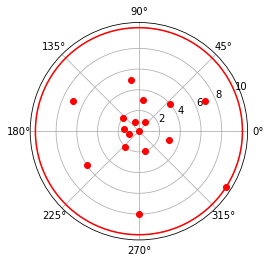

In [92]:
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(np.linspace(0, 2*np.pi, 100), np.ones(100)*10, color='r', linestyle='-')
plt.plot([0,1,1,1.5,2,2,3,4,5,7,6,8,10,7,3,2,1], 'ro')
plt.show()

The center of the circle is the real value, and few dots represent an example of how the values are distributet near the real value. Now, if calculate a number of dots in each concentric cirkle, we will get noraml or Gaussian distribution.

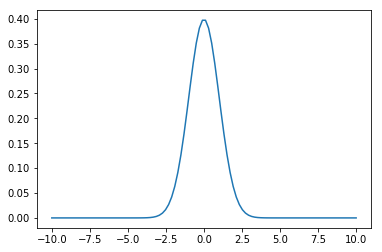

In [93]:
mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(-10, 10, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))

plt.show()

Where the most of the dots are positioned in the nearest circle to the real value. Hopefully, this explains normal distribution.
Now, in our case, we can not leave scale to be in one state for 24h. If we leaved it, the distribution around the real value would be similar to the example above. But, we know that the distribution will be like that, so based on that knowladge we could do something.
So, there are two requirements that needs to be fullfiled if we want to use Kalman filter:
Lienar change of state
Gaussian (normal) distribution
Both of them are in our case fullfiled.
So, what is the Kalman filter?
Kalman filter 'knows' that the distribution is normal and the movement is linear so it predicts next state based on these presumtions and the previous step. How? First, in our algorithm, we need to 'say' to the Kalman filter what is the model of the movement (movement in a sense of how the linear function looks like). If we are measuring the real physical movement using the accelerometer, in the model for the next state we need to include basic kinematic formulas.

The prediction step looks like this:
x[k] = a*x[k-1] + Buk

Kalman filter first of all predicts next step based on the previous step and transition model. Then predicts error based also on previous steps. The prediction phase is finished. Next phase is to update states. Update means first to calculate how much predicted value deviate from the value taken from the sensor (y). Then based on that knowledge update the weights (Kalaman gain - kg). This Kalman gain will give us the information of how much we trust sensor and how much we need to 'move' our predicted value to the value coming from the sensor. That is how we get Wk - updated predicted value.
This is the simpliest case of the Kalman filter because we only have one variable and we are therefore using one dimensional matrix.

On the next graph comparation of the raw data and filtered data is shown.

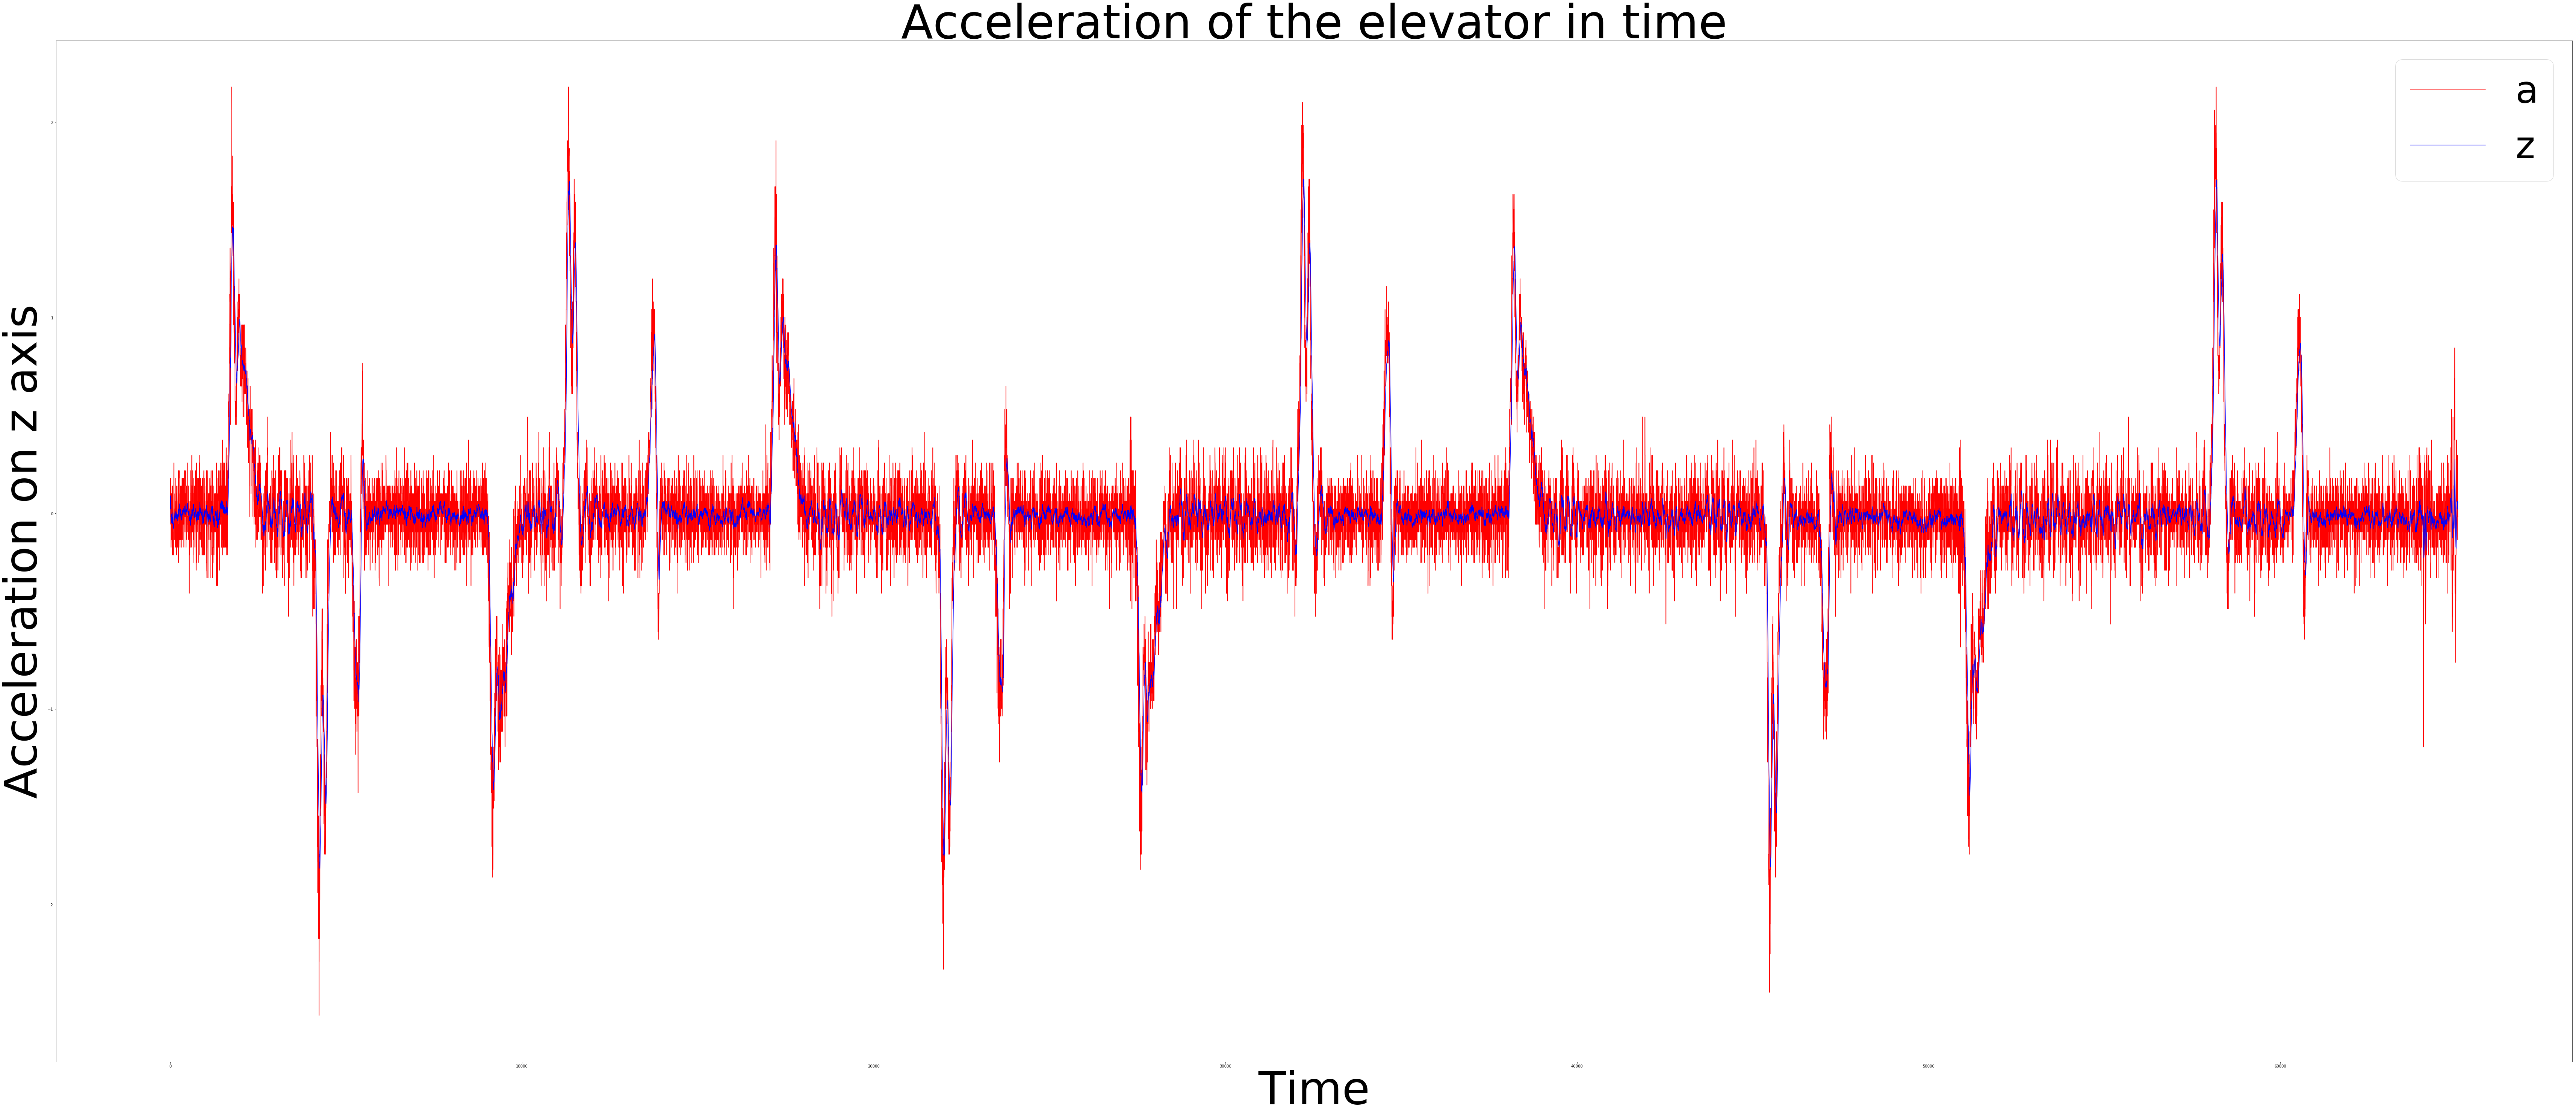

In [94]:
az_kalman = []
vz_kalman = []
vz_raw_list = []
pks_list = []
azk = 0.1
Pkprev = 1.0
Hprev = 1
q = 0.0001
azprev = 0.0
vzp = 0.0
vzp_raw = 0.0

for z in range (0, len(az_raw)):

    #prediction
    a = 1

    azpredicted = float(a*azk)               #x[k] = a*x[k-1] + Buk
    Pk = a*Pkprev*a + q                          #p[k] = a * p[k - 1] * a + q

    #update 
    y = float(az_raw[z]) - Hprev*azpredicted   #y = z - h * x[k]
    kg = Pk*Hprev/(Hprev*Pk*Hprev + 0.1)        #kg = p * h / (h * p * h + r)
    azk = azpredicted + kg*y                    #x[k] = x[k] + kg * y
    Pk = (1 - Hprev*kg)*Pk                      #p[k] = (1 - kg * h) * p[k]

    
    
    az_kalman.append(azk)
    
    dt=1


    vz = vzp + azk*dt
    vz_raw = vzp_raw + float(az_raw[z])
    
    
    vz_kalman.append(vz)
    vz_raw_list.append(vz_raw)
    
    vzp = vz
    vzp_raw = vz_raw
    azprev = azk
    Pkprev = Pk
    
pylab.figure(figsize=(120,50))
pylab.plot(range(len(az_raw)),az_raw,'r', range(len(az_kalman)),az_kalman,'b')
pylab.xlabel('Time', fontsize=120)
pylab.ylabel('Acceleration on z axis', fontsize=120)
pylab.title('Acceleration of the elevator in time', fontsize=124)
pylab.legend('az', fontsize=100)
pylab.show()


# Velocity

Finding velocity from the filtered data is done by integreting the acceleration over time.

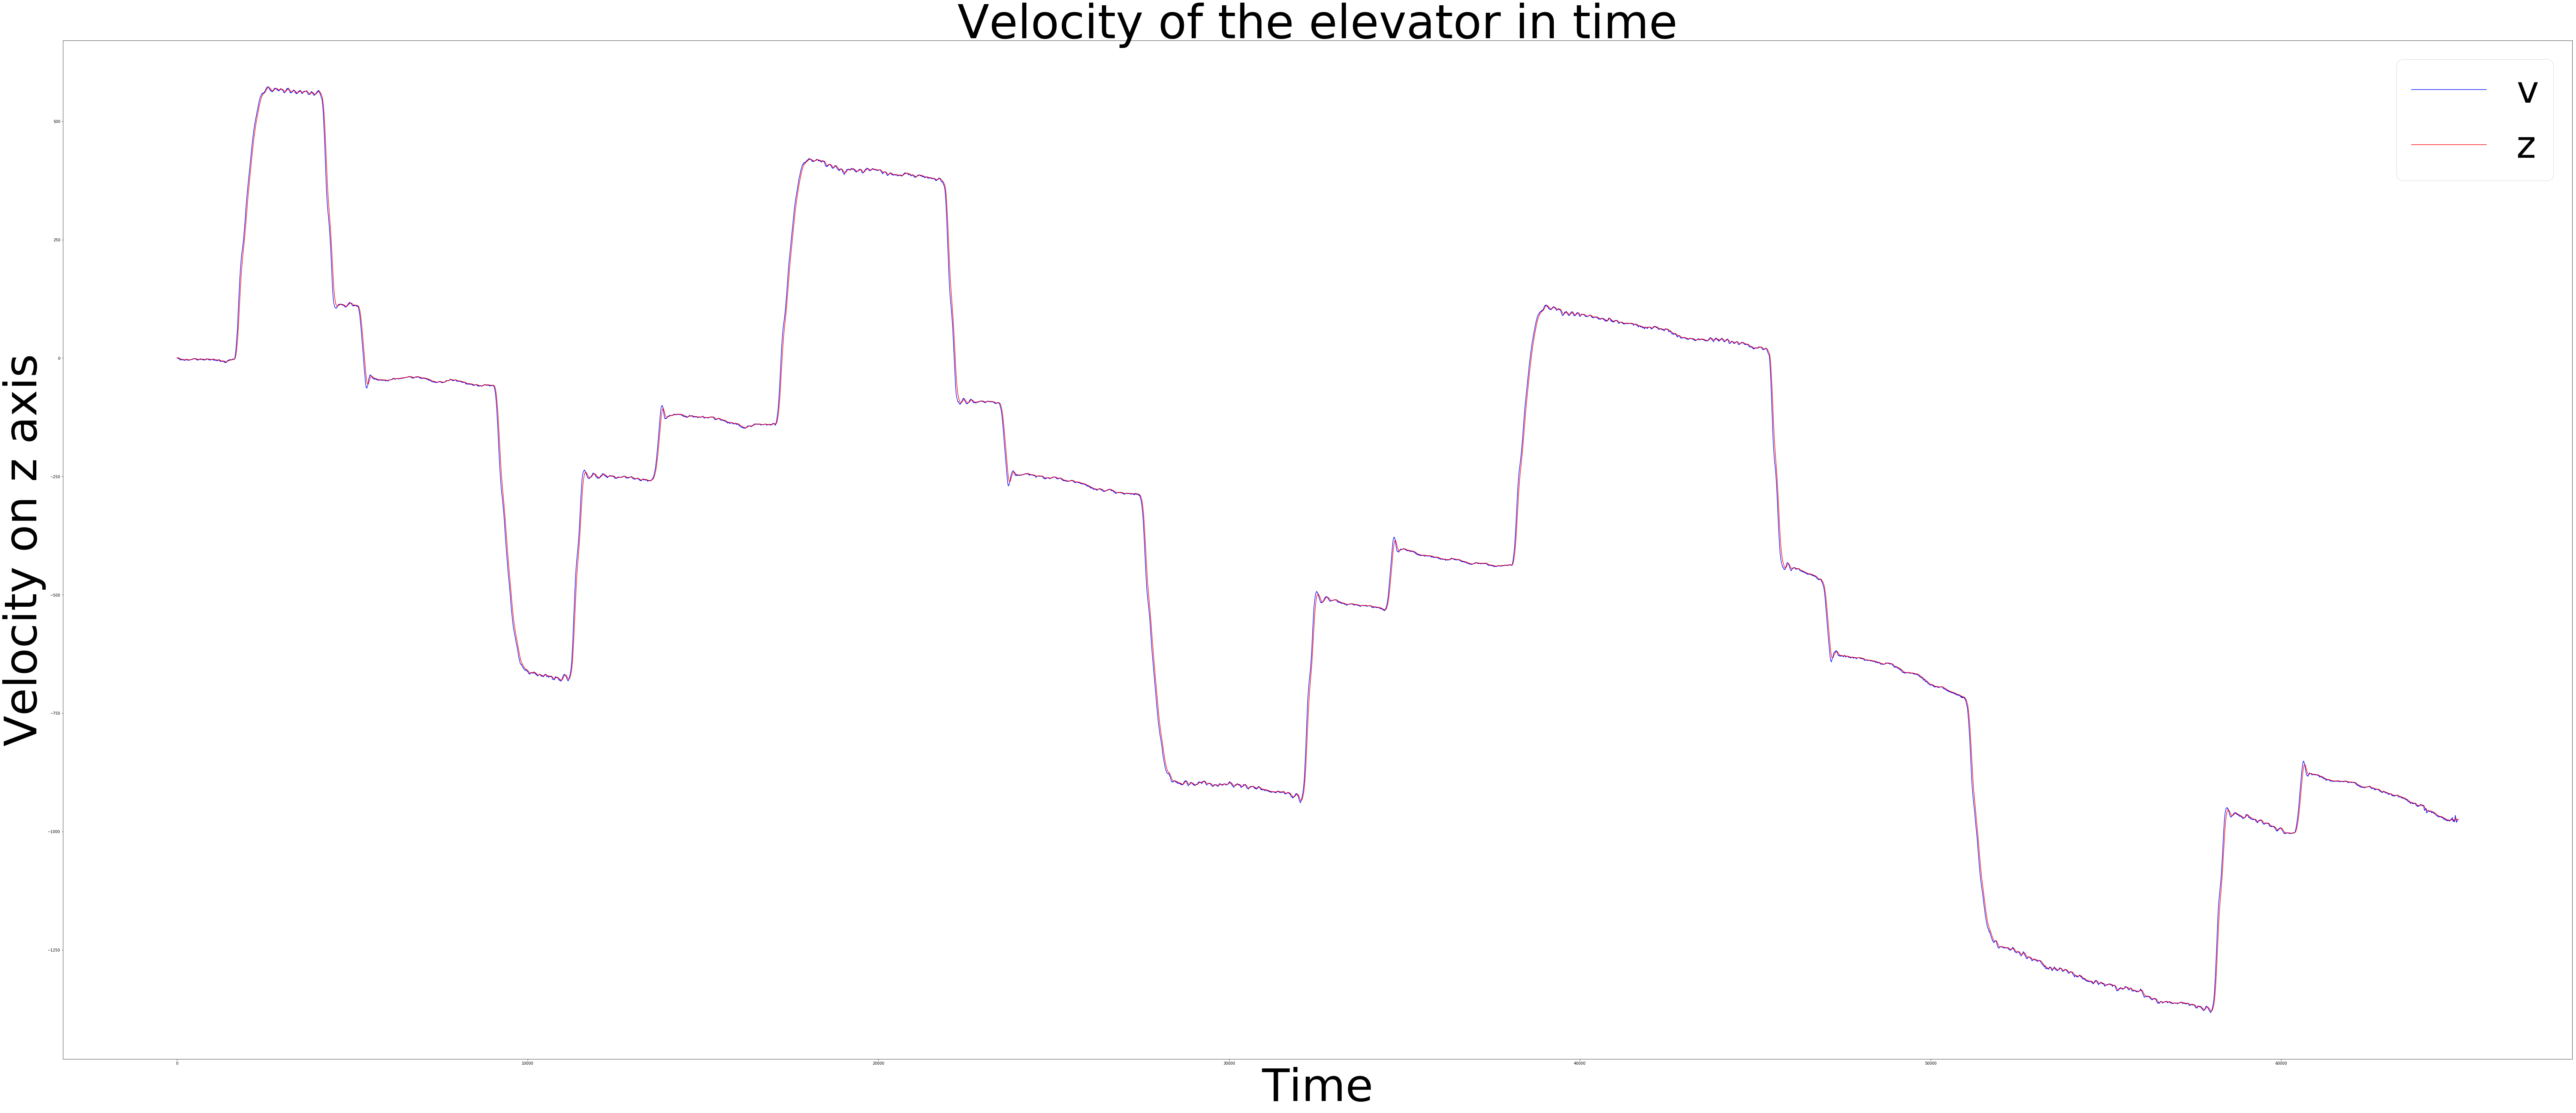

In [95]:
az_kalman = []
vz_kalman = []
vz_raw_list = []
pks_list = []
azk = 0.1
Pkprev = 1.0
Hprev = 1
q = 0.0001
azprev = 0.0
vzp = 0.0
vzp_raw = 0.0

for z in range (0, len(az_raw)):

    #prediction
    a = 1

    azpredicted = float(a*azk)               #x[k] = a*x[k-1] + Buk
    Pk = a*Pkprev*a + q                          #p[k] = a * p[k - 1] * a + q

    #update 
    y = float(az_raw[z]) - Hprev*azpredicted   #y = z - h * x[k]
    kg = Pk*Hprev/(Hprev*Pk*Hprev + 0.1)        #kg = p * h / (h * p * h + r)
    azk = azpredicted + kg*y                    #x[k] = x[k] + kg * y
    Pk = (1 - Hprev*kg)*Pk                      #p[k] = (1 - kg * h) * p[k]

    
    
    az_kalman.append(azk)
    
    dt=1


    vz = vzp + azk*dt
    vz_raw = vzp_raw + float(az_raw[z])
    
    
    vz_kalman.append(vz)
    vz_raw_list.append(vz_raw)
    
    vzp = vz
    vzp_raw = vz_raw
    azprev = azk
    Pkprev = Pk
    


pylab.figure(figsize=(120,50))
pylab.plot(range(len(vz_raw_list)),vz_raw_list,'b', range(len(vz_kalman)),vz_kalman,'r')
pylab.xlabel('Time', fontsize=120)
pylab.ylabel('Velocity on z axis', fontsize=120)
pylab.title('Velocity of the elevator in time', fontsize=124)
pylab.legend('vz', fontsize=100)
pylab.show()

Altrough we could see that Kalman filter did a great job with the acceleration the velocity error remains. That is why we did take this graph of the velocity and mesured time of the movement. On the velocty graph it is completly clear when the elevator is moving and when it it staying still. If we look at that pattern, we could measure time of the movement and by knowing the time needed for elevator to come from one floor to some other we could know the number of floor traveled. Also by knowing the distance between the floors, we could know the distance traveled by the elevator.

We could also find the distance from the velocity, by integrating it, bu tas shown, the error is too big and that wouldn't be the valid information.

# Kraj

Na dalje nije bitno, to su moji pokusaji.

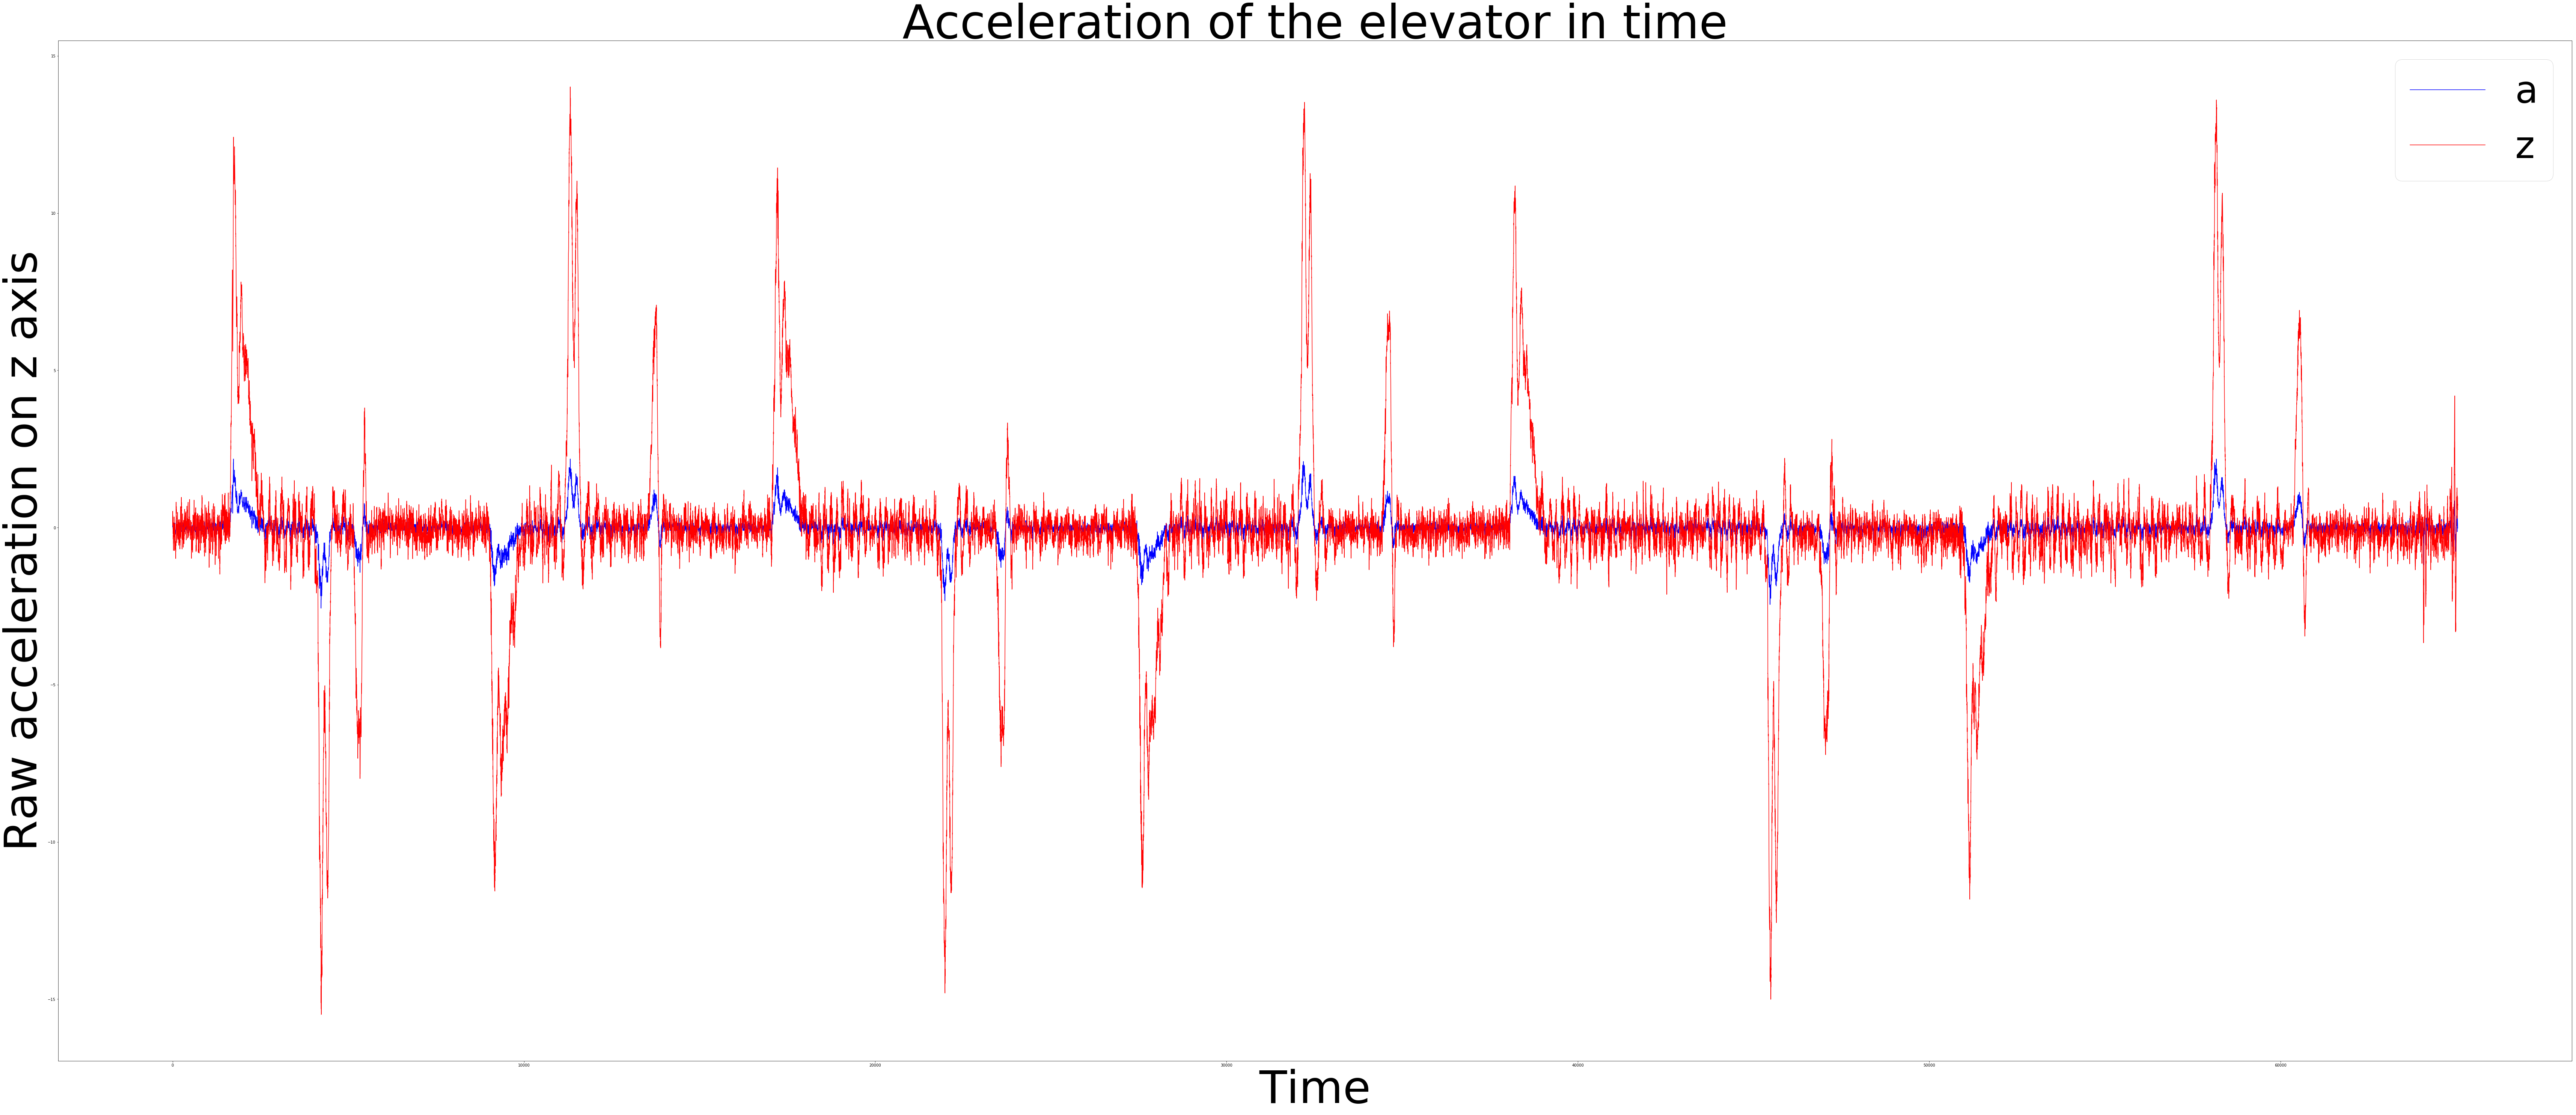

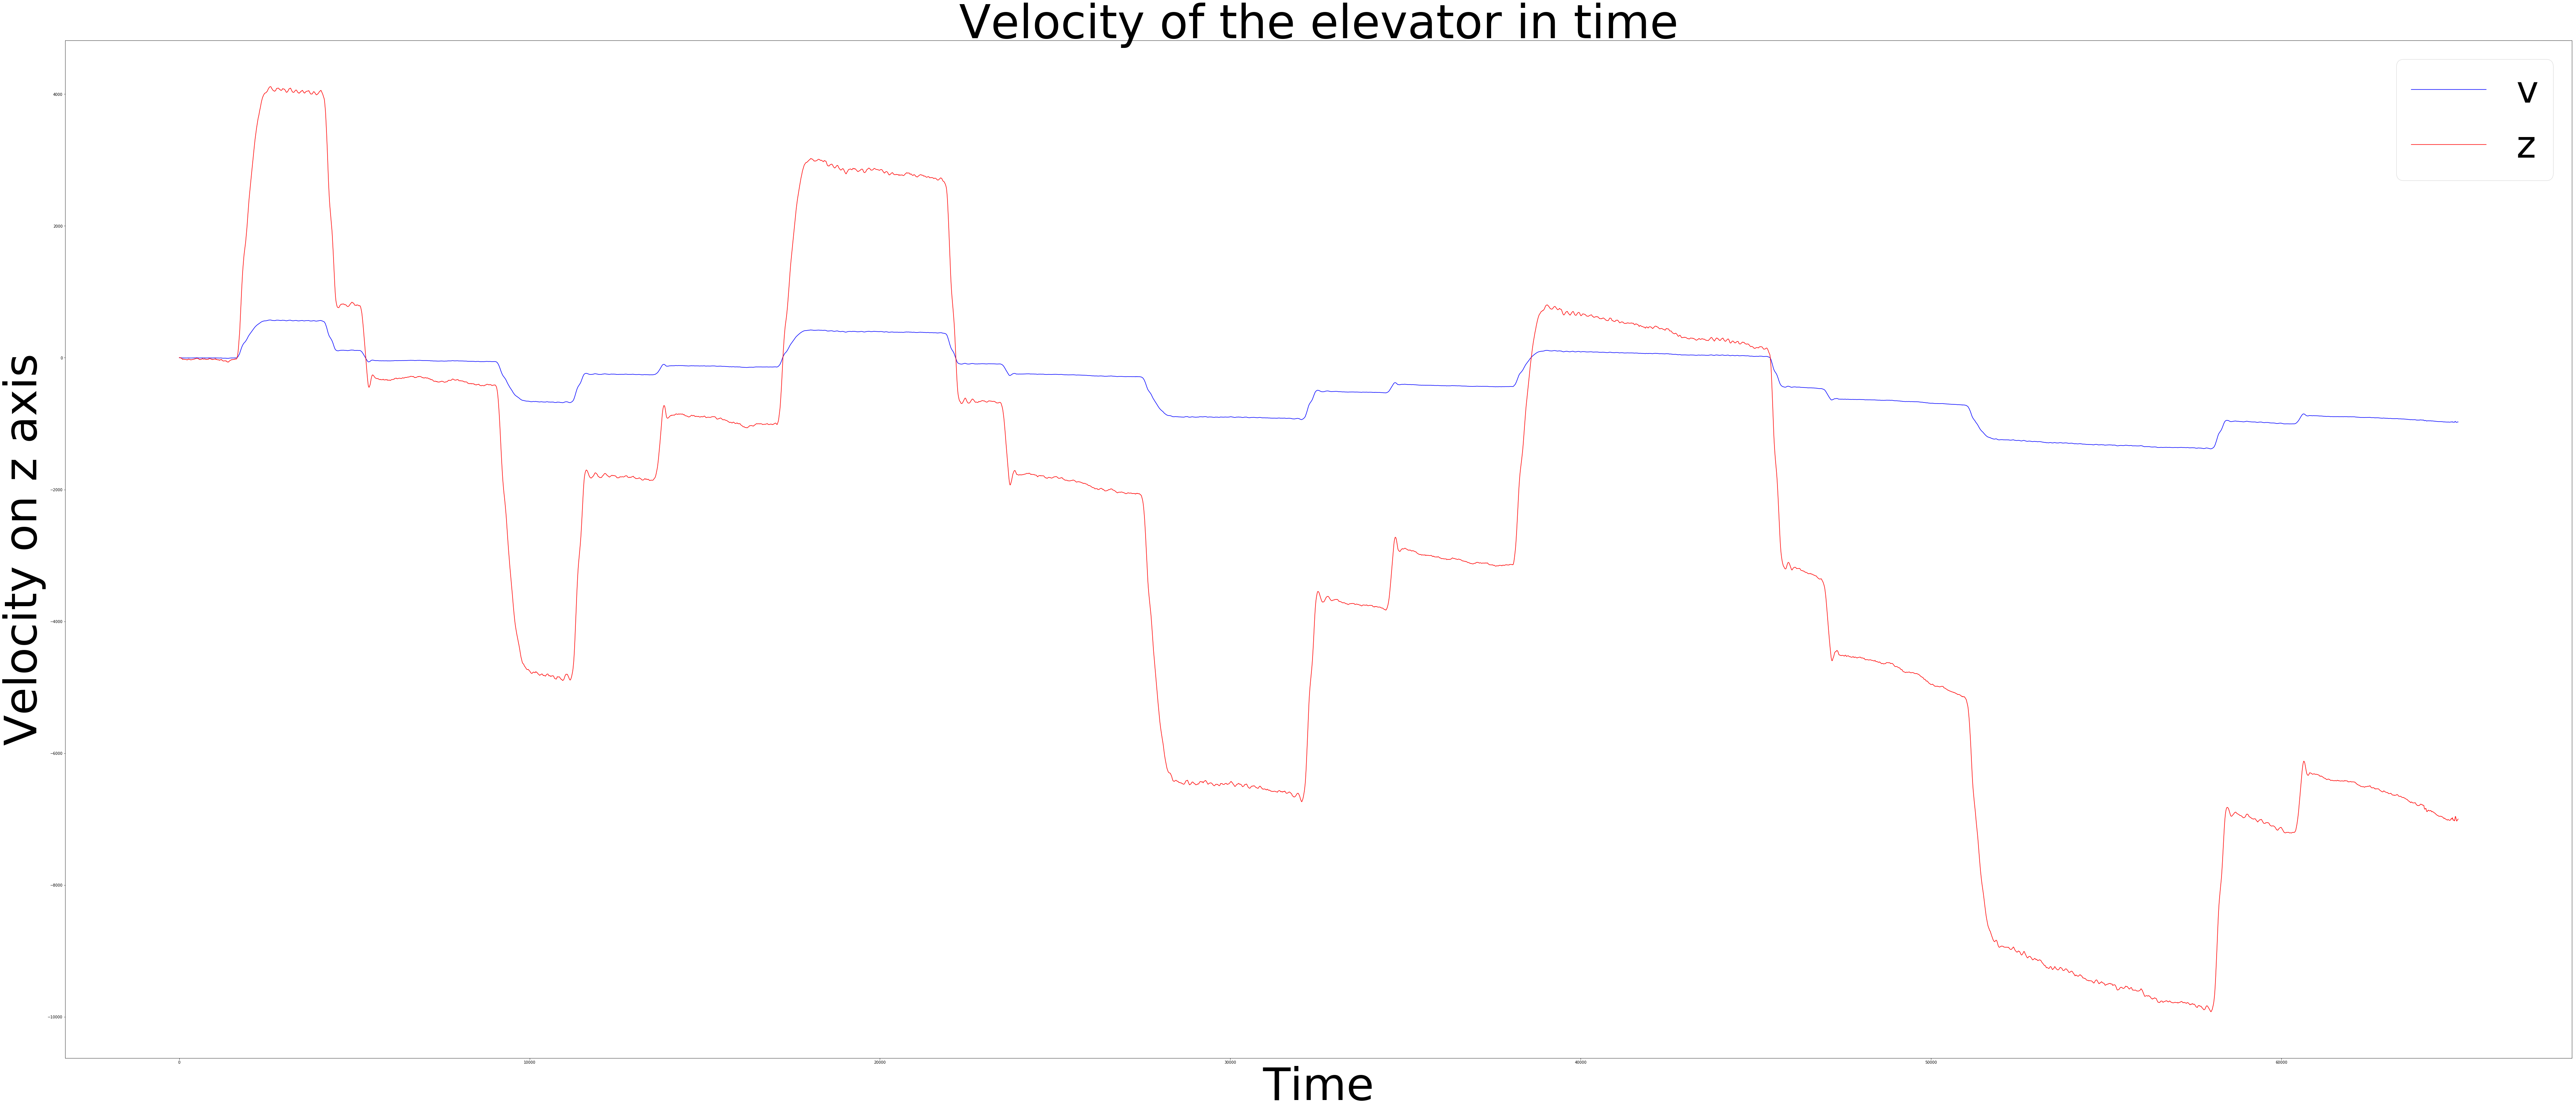

In [96]:
az_kalman_new = []
vz_kalman_new = []
pks_list = []
vzp = 0.0

H = np.matrix('1.0 0.0; 0.0 1.0')
A = np.matrix('1.0 1.0; 0.0 1.0')
R = np.matrix('0.1 0.0; 0.0 0.1')
Pk = np.matrix('0.1 0.0; 0.0 0.1')
azk = 0.1
Q = np.matrix('0.01 0.0; 0.0 0.01')

for z in range (0, len(az_raw)):

    #prediction
    azpredicted = A*azk  #np.multiply(A,azk)               #x[k] = a*x[k-1] + Buk
    Pk = A*Pk*np.transpose(A) + Q                          #p[k] = a * p[k - 1] * a + q

    #update 
    y = float(az_raw[z]) - H*azpredicted   #y = z - h * x[k]
    kg = Pk*np.transpose(H)/(H*Pk*np.transpose(H) + R)        #kg = p * h / (h * p * h + r)
    azk = azpredicted + kg*y                    #x[k] = x[k] + kg * y
    Pk = (1 - H*kg)*Pk                      #p[k] = (1 - kg * h) * p[k]

    
    az_kalman_new.append(azk[0,0])
    
    #daz = azk[0,0] - azprev
    dt=1

    vz = vzp + azk[0,0]*dt
    
    vz_kalman_new.append(vz)
    
    vzp = vz
    #if z>64000 and z<65000:
        #print(vz)
    
    
pylab.figure(figsize=(120,50))
pylab.plot(range(len(az_raw)),az_raw,'b', range(len(az_kalman_new)),az_kalman_new,'r')
pylab.xlabel('Time', fontsize=120)
pylab.ylabel('Raw acceleration on z axis', fontsize=120)
pylab.title('Acceleration of the elevator in time', fontsize=124)
pylab.legend('az', fontsize=100)
pylab.show()

pylab.figure(figsize=(120,50))
pylab.plot(range(len(vz_raw_list)),vz_raw_list,'b', range(len(vz_kalman_new)),vz_kalman_new,'r')
pylab.xlabel('Time', fontsize=120)
pylab.ylabel('Velocity on z axis', fontsize=120)
pylab.title('Velocity of the elevator in time', fontsize=124)
pylab.legend('vz', fontsize=100)
pylab.show()

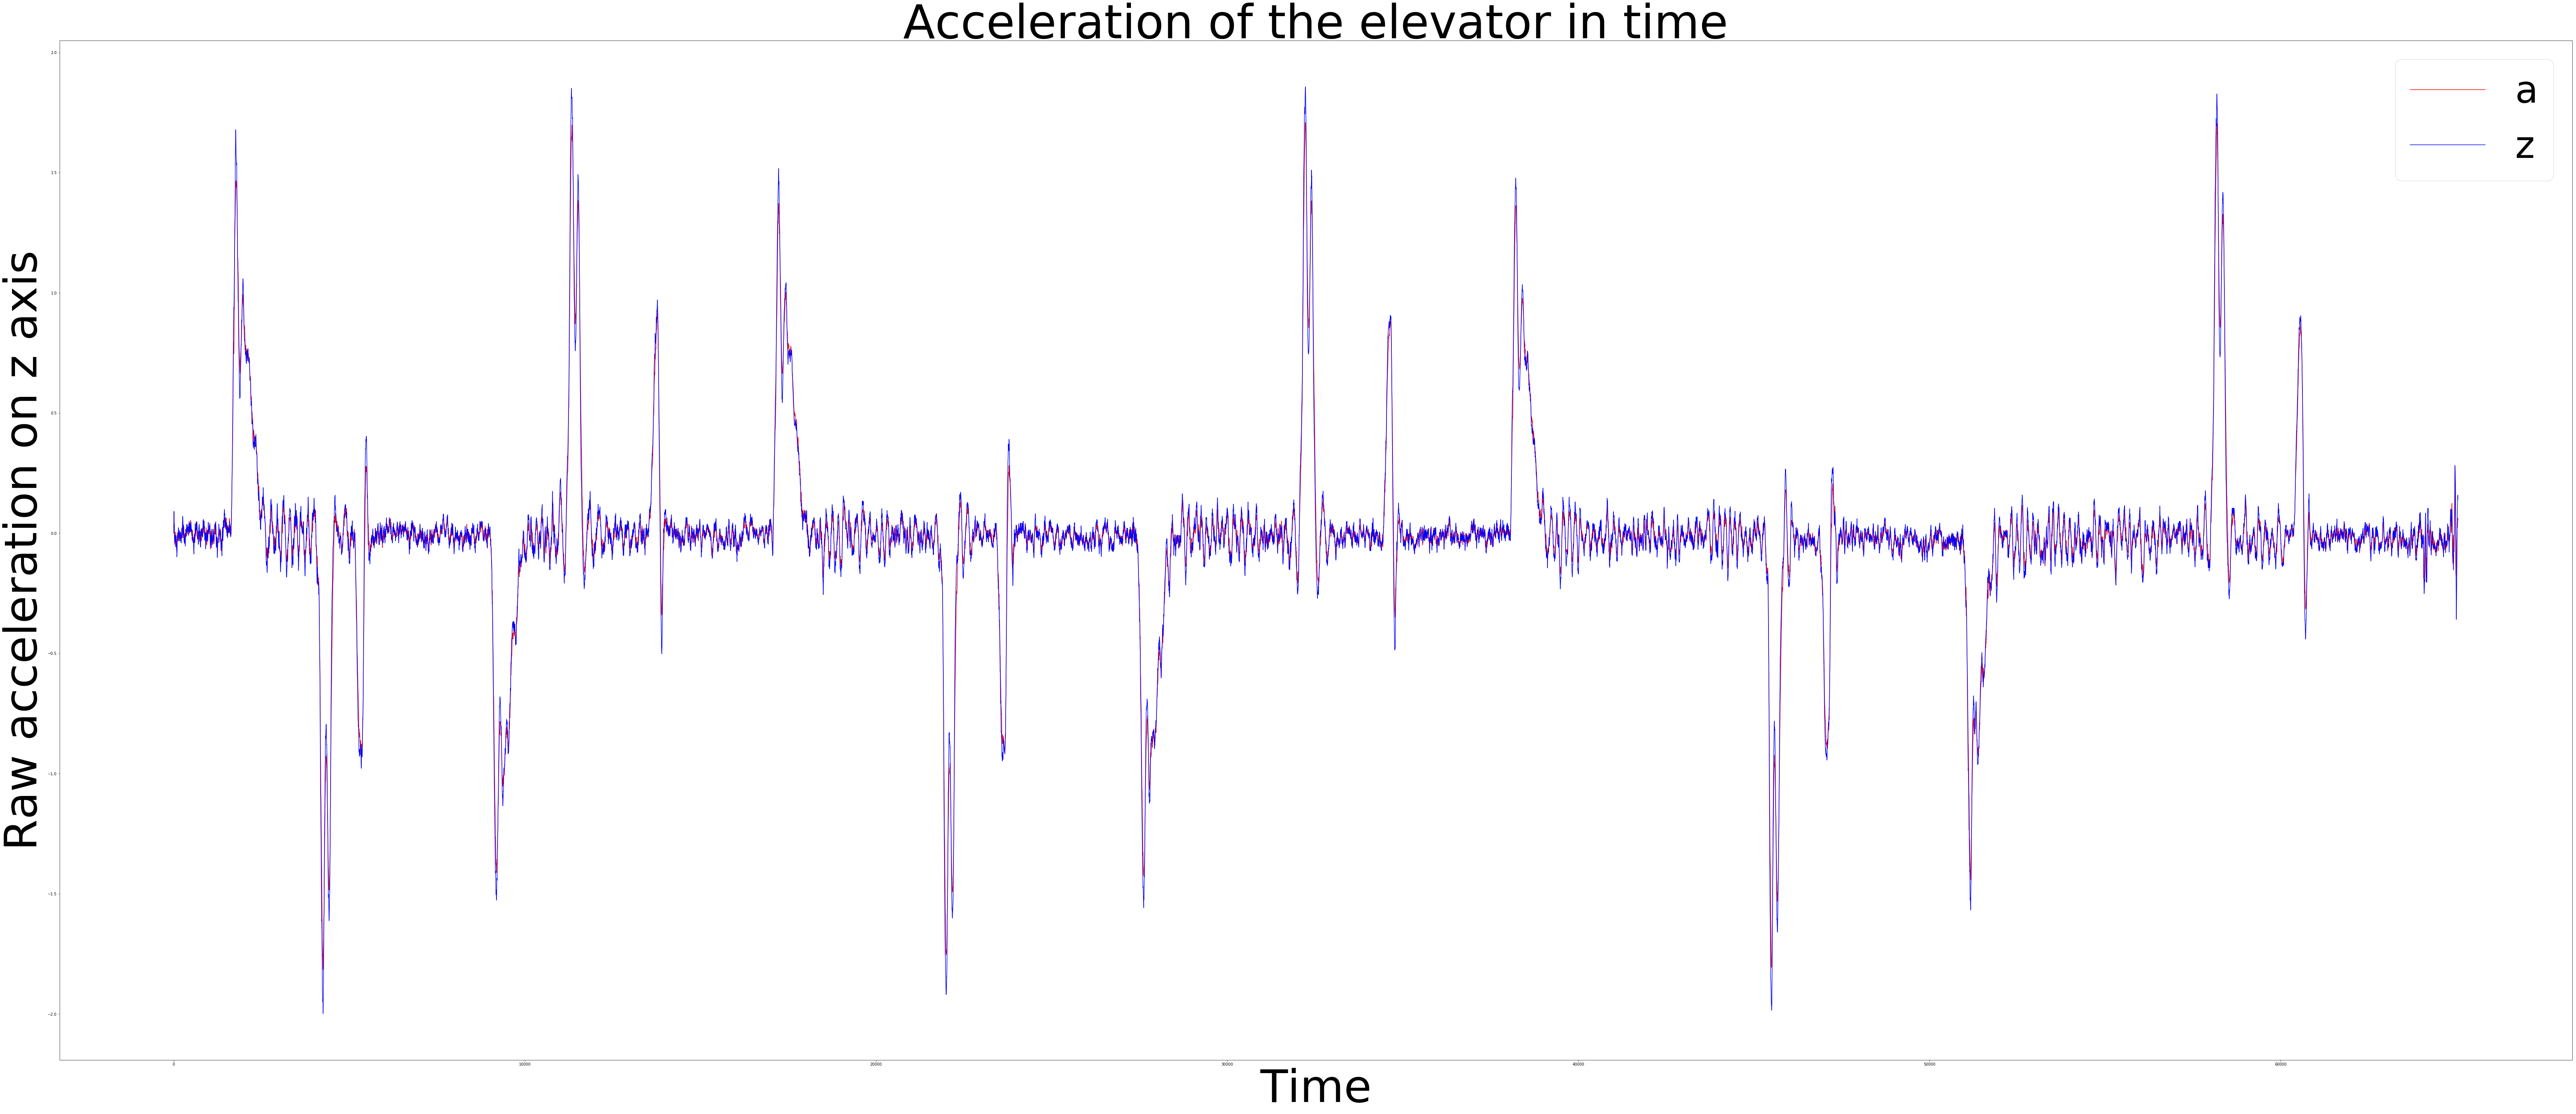

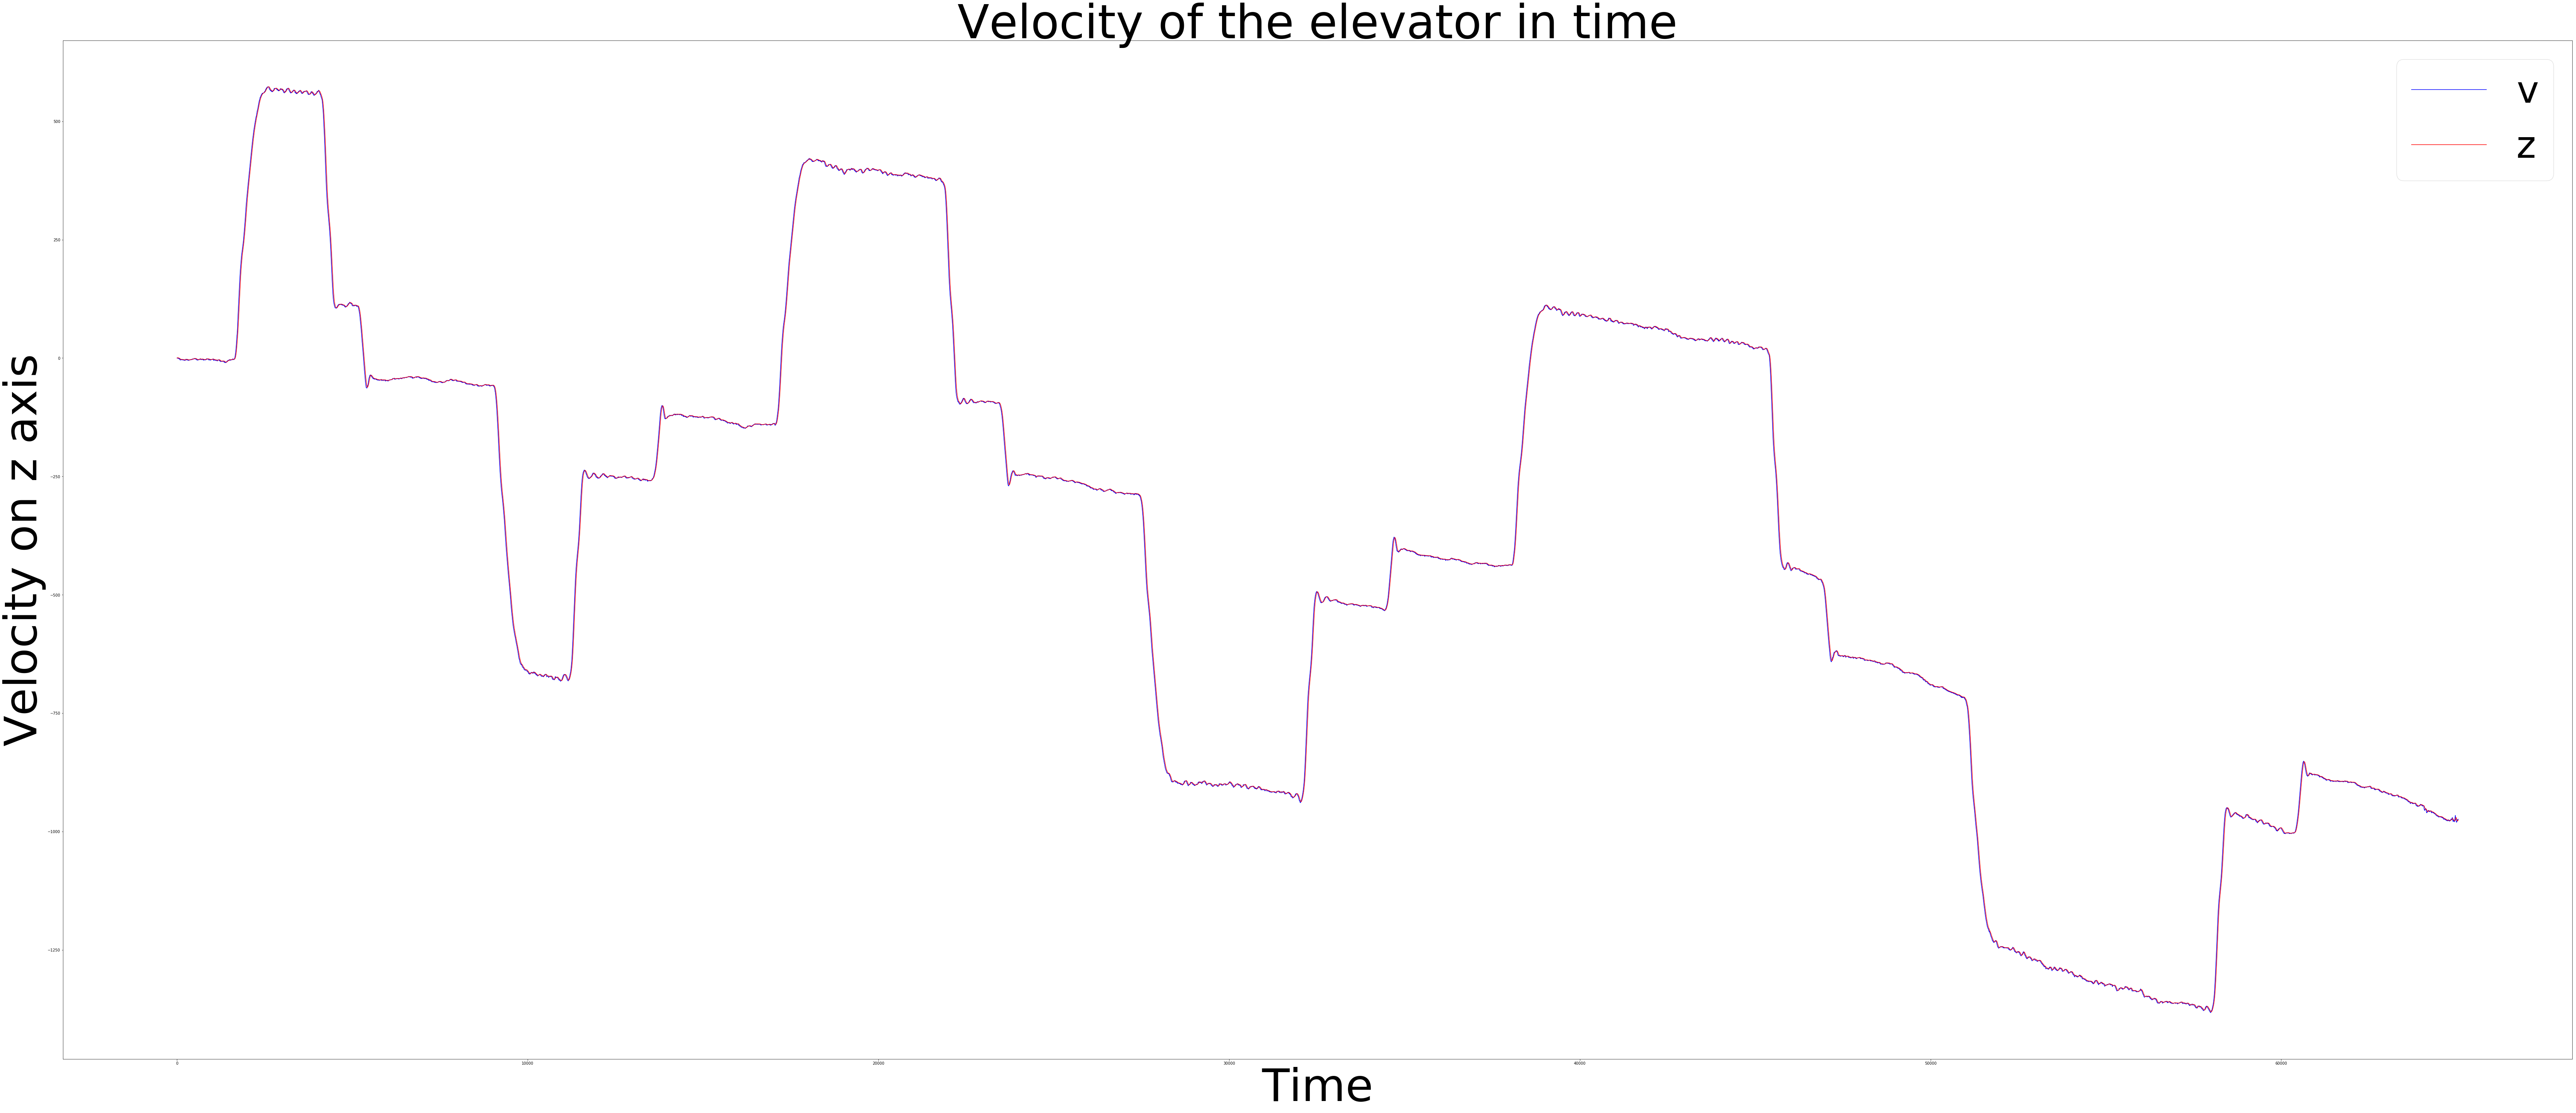

In [97]:
az_average = []
vz_average = []
vzp = 0.0
i = 0

for z in range (0, len(az_raw)):

    mean40 = 0.0
    sum = 0.0
    n = 0
    br = 0
    if z > 40:
        n = z - 40
    for i in range(n, z):
        #if mean[i] != 0:
        sum = sum + float(az_raw[i])
        br = br + 1
    if i > 0 and  br > 0:
        mean40 = sum/br
    else:
        mean40 = sum
        
    az_average.append(mean40)
    
    vz = vzp + mean40*dt
    
    vz_average.append(vz)
    
    vzp = vz
    
    
pylab.figure(figsize=(120,50))
pylab.plot(range(len(az_kalman_new)),az_kalman,'r', range(len(az_average)),az_average,'b')
pylab.xlabel('Time', fontsize=120)
pylab.ylabel('Raw acceleration on z axis', fontsize=120)
pylab.title('Acceleration of the elevator in time', fontsize=124)
pylab.legend('az', fontsize=100)
pylab.show()

pylab.figure(figsize=(120,50))
pylab.plot(range(len(vz_raw_list)),vz_raw_list,'b', range(len(vz_average)),vz_average,'r')
pylab.xlabel('Time', fontsize=120)
pylab.ylabel('Velocity on z axis', fontsize=120)
pylab.title('Velocity of the elevator in time', fontsize=124)
pylab.legend('vz', fontsize=100)
pylab.show()